In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import sys
import datetime

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# Check used versions
now = datetime.datetime.now()
print("Date-time           ", now)
print("Tf version:         ", keras.__version__)
print("Numpy version:      ", np.__version__)
print("Python              ", sys.executable)
print("Python version      ", sys.version)

Date-time            2021-07-27 16:11:39.959194
Tf version:          2.3.0-tf
Numpy version:       1.19.1
Python               /net/software_g4rt/anaconda3/envs/condaenv-sificcnn/bin/python
Python version       3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [3]:
%%time
# model name
model_name = 'model-2b-lsr-enough-repro'

shuffle_clusters = False

# load the training data
data = DataModel('data-enough-8cl-emax.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# randomly shuffle the training data
#np.random.seed(888)
#ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

CPU times: user 2.47 s, sys: 950 ms, total: 3.42 s
Wall time: 3.45 s


In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [5]:
%%time
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 90:
        return .0003
    elif epoch < 160:
        return .0001
    elif epoch < 180:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

CPU times: user 15.1 ms, sys: 3.03 ms, total: 18.2 ms
Wall time: 19.5 ms


In [6]:
%%time
#TRAINING
# start the training
#ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.2 µs


In [7]:
ai.load("ModelsTrained/" + model_name, optimizer=False)

In [8]:
#ai.evaluate()

In [9]:
# evaluate the AI on the training set
#ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)

In [10]:
# plot the training loss
#ai.plot_training_loss(smooth=False)

In [11]:
#ai.plot_training_loss(smooth=False, mode='loss')

In [12]:
ai.isInsideVolume(mask = 'type', data = 'prediction')

     15383 Events (matched)

     14840 Events e predicted inside scatterer
       467 Events e predicted inside absorber
        76 Events e pred. outside of volumes
  0.4941 Percent of outside pred. from all (matched) events

            40 ( 52.6316 %) x missed, e-
             0 (  0.0000 %) y missed, e-
            36 ( 47.3684 %) z missed, e-

       460 Events ph predicted inside scatterer,
     14781 Events ph predicted inside absorber
       142 Events ph outside of volumes
  0.9231 Percent of hits from all (matched) events

            77 ( 54.2254 %) x missed, photon
            31 ( 21.8310 %) y missed, photon
            38 ( 26.7606 %) z missed, photon


In [13]:
ai.isInsideVolume(mask = 'type', data = 'true')

     15383 Events (matched)

     14709 Events e predicted inside scatterer
       639 Events e predicted inside absorber
        35 Events e pred. outside of volumes
  0.2275 Percent of outside pred. from all (matched) events

             0 (  0.0000 %) x missed, e-
             0 (  0.0000 %) y missed, e-
            35 (100.0000 %) z missed, e-

       638 Events ph predicted inside scatterer,
     14681 Events ph predicted inside absorber
        64 Events ph outside of volumes
  0.4160 Percent of hits from all (matched) events

             0 (  0.0000 %) x missed, photon
             0 (  0.0000 %) y missed, photon
            64 (100.0000 %) z missed, photon


In [14]:
ai.isInsideVolume(mask = 'all', data = 'true')

      2605 Events (matched)

      2543 Events e predicted inside scatterer
        59 Events e predicted inside absorber
         3 Events e pred. outside of volumes
  0.1152 Percent of outside pred. from all (matched) events

             0 (  0.0000 %) x missed, e-
             0 (  0.0000 %) y missed, e-
             3 (100.0000 %) z missed, e-

        59 Events ph predicted inside scatterer,
      2538 Events ph predicted inside absorber
         8 Events ph outside of volumes
  0.3071 Percent of hits from all (matched) events

             0 (  0.0000 %) x missed, photon
             0 (  0.0000 %) y missed, photon
             8 (100.0000 %) z missed, photon


In [15]:
ai.isInsideVolume(mask = 'all')

      2605 Events (matched)

      2544 Events e predicted inside scatterer
        59 Events e predicted inside absorber
         2 Events e pred. outside of volumes
  0.0768 Percent of outside pred. from all (matched) events

             1 ( 50.0000 %) x missed, e-
             0 (  0.0000 %) y missed, e-
             1 ( 50.0000 %) z missed, e-

        58 Events ph predicted inside scatterer,
      2529 Events ph predicted inside absorber
        18 Events ph outside of volumes
  0.6910 Percent of hits from all (matched) events

             6 ( 33.3333 %) x missed, photon
             7 ( 38.8889 %) y missed, photon
             5 ( 27.7778 %) z missed, photon


In [16]:
ai.isInsideVolume(mask = '')

     65668 Events (matched)

     60416 Events e predicted inside scatterer
      2741 Events e predicted inside absorber
      2511 Events e pred. outside of volumes
  3.8238 Percent of outside pred. from all (matched) events

          2397 ( 95.4600 %) x missed, e-
             7 (  0.2788 %) y missed, e-
           133 (  5.2967 %) z missed, e-

      2329 Events ph predicted inside scatterer,
     58431 Events ph predicted inside absorber
      4908 Events ph outside of volumes
  7.4740 Percent of hits from all (matched) events

          4516 ( 92.0130 %) x missed, photon
           176 (  3.5860 %) y missed, photon
           314 (  6.3977 %) z missed, photon


Check argument of arccos: Invalid events 123  from  15383
  Number of valid events (arccos): 15260.00000
  Number of valid events (arccos): 7378.00000       
  Sanity check (No. y_OM larger y_OC): 7378.00000   
  No. axis missed, pos y_OC, 0 tolerance:  0.00000
  No. axis missed, pos y_OC, 5 tolerance:  0.00000
  No. axis missed, pos y_OC, %:      nan          
  No. axis missed, neg y_OC, 0 tolerance: 424.00000
  No. axis missed, neg y_OC, 5 tolerance: 96.00000
  No. axis missed, neg y_OC, %:  1.30117          
Outliers in MCtruth [[   0.   8256.34  -21.88]
 [   0.   1568.26   80.24]] [[382.   -35.7  -48.22]
 [205.74 -21.27  18.14]]


/.automount/home/home__home2/institut_3b/profe/Software/DeepLearning/SiFi-CC-NN/sificc_lib/AI.py:1259: RuntimeWarning: invalid value encountered in long_scalars
  print('  No. axis missed, pos y_OC, %: {:8.5f}          '.format( 100*np.sum([array_OM[:,1][array_OC[:,1]>0]>5]) / len(array_OM[:,1][array_OC[:,1]>0]) ))
No handles with labels found to put in legend.
No handles with labels found to put in legend.


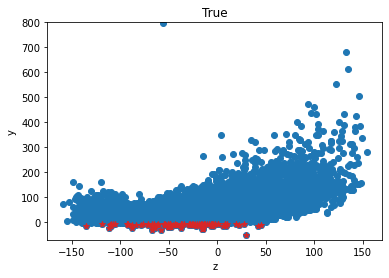

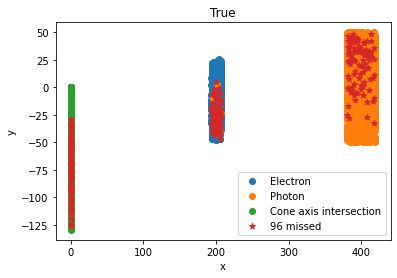

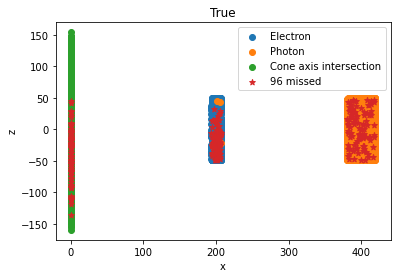

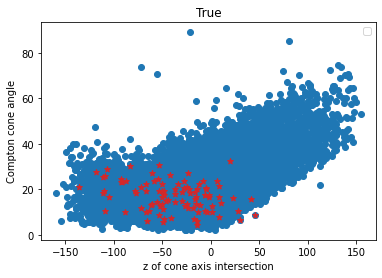

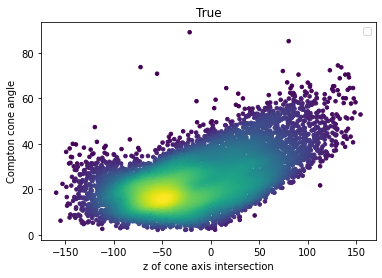

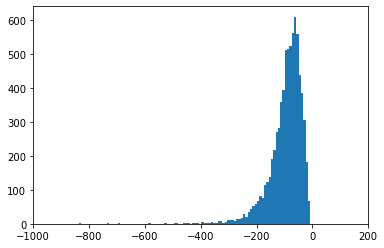

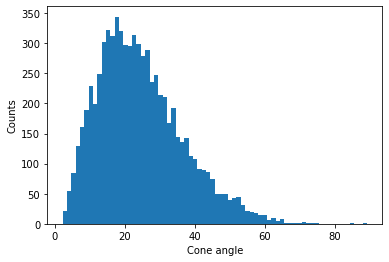

In [17]:
ai.savefigpath = '/home/home2/institut_3b/profe/Data/SiFiCCNN/21-07-EventAnalysis-ComptonConeDirection/Negative_Yoc_Forward/'

ai.evaluationComptonCones(mask = 'type', events='True', save = True) # with Rotation matrix

Check argument of arccos: Invalid events 36  from  9338
  Number of valid events (arccos): 9302.00000
  Number of valid events (arccos): 4479.00000       
  Sanity check (No. y_OM larger y_OC): 4479.00000   
  No. axis missed, pos y_OC, 0 tolerance:  0.00000
  No. axis missed, pos y_OC, 5 tolerance:  0.00000
  No. axis missed, pos y_OC, %:      nan          
  No. axis missed, neg y_OC, 0 tolerance: 265.00000
  No. axis missed, neg y_OC, 5 tolerance: 53.00000
  No. axis missed, neg y_OC, %:  1.18330          
Outliers in MCtruth [[   0.   1568.26   80.24]] [[205.74 -21.27  18.14]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


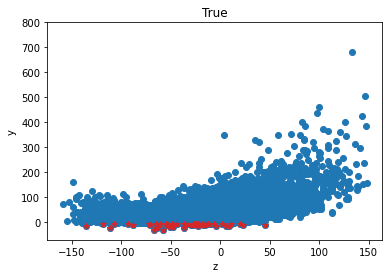

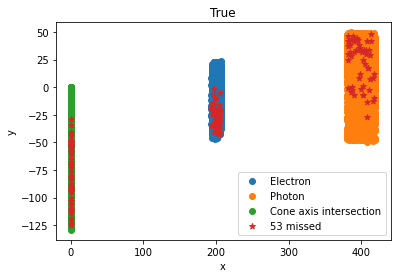

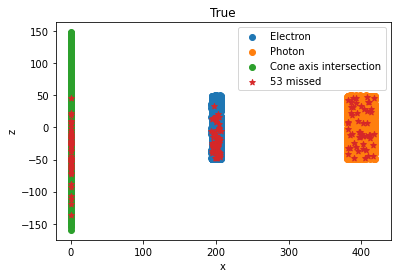

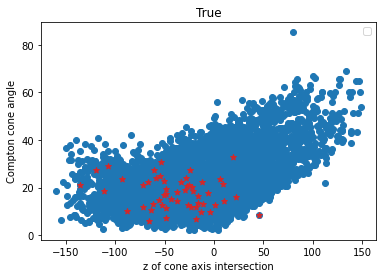

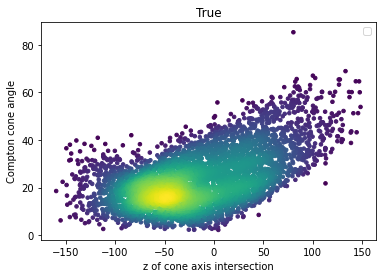

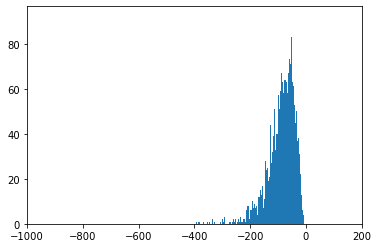

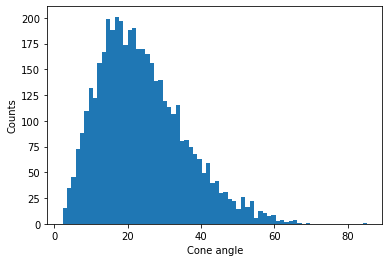

In [18]:
ai.evaluationComptonCones(mask = 'position', events='True', save = True) 

In [19]:
ai.evaluationComptonCones(mask = '', events='True', save = True) 

Y pred [[  0.    12.82  -1.13 ...   2.85  -2.74 -15.35]
 [  1.    -4.95  -3.46 ...   7.48  -9.47  -0.71]
 [  1.     2.04  32.43 ...   2.25  15.61  -6.65]
 ...
 [  0.    51.06   2.23 ...  -1.09   1.31 -10.61]
 [  1.     0.21   4.57 ...   5.98  -3.36 -12.66]
 [  0.     2.63   5.07 ...  -1.12   6.2  -13.44]]
Y pred [False  True  True ... False  True False]
[[  1.    -4.95  -3.46 ...   7.48  -9.47  -0.71]
 [  1.     2.04  32.43 ...   2.25  15.61  -6.65]
 [  1.    -5.8    0.47 ...   4.2   -4.1    7.04]
 ...
 [  1.    -5.45  -7.88 ...   2.26  -3.25   4.58]
 [  1.     2.04   3.66 ...   5.11  -0.13  -9.46]
 [  1.     0.21   4.57 ...   5.98  -3.36 -12.66]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 20099 but corresponding boolean dimension is 18399

In [ ]:
ai.evaluationComptonCones(mask = 'type', events='Prediction', save = True)

In [ ]:
ai.evaluationComptonCones(mask = 'position', events='Prediction', save = True)

In [ ]:
ai.evaluationComptonCones(mask = '', events='Prediction', save = True)

In [ ]:
ai.evaluationComptonCones(mask = 'all', events='True', save = True)

In [ ]:
#ai.evaluationComptonCones(mask = '', events='Prediction')

In [ ]:
# ai.plot_diff()

In [ ]:
# evaluate the AI on the test dataset
#ai.evaluate()

In [ ]:
# save the trained model
#ai.save(file_name=model_name)